In [2]:
!pip install lightgbm numpy h5py

In [ ]:
! unzip /kaggle/input/models.zip -d /kaggle/working

In [ ]:
# unzip the test-model
import zipfile

# Specify the path to the ZIP file
zip_path = '../input/models.zip'

# Open the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all files and directories to the current working directory
    zip_ref.extractall()

In [3]:
import torch
import pandas as pd
import numpy as np
import h5py
import json
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import gc
from sklearn.model_selection import KFold
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [24]:
train_input = torch.from_numpy(np.load("/kaggle/input/ltb-regression/cite_train_X.npy"))
print(train_input.shape)
target = h5py.File('/kaggle/input/ltb-regression/cite_train_y.h5', 'r')
target_df = pd.read_hdf('/kaggle/input/ltb-regression/cite_train_y.h5')
np.save('cite_train_y.npy', target_df.to_numpy())

torch.Size([70988, 553])


In [25]:
y_columns = list(target_df.columns)
Y = target_df.values
print(f"target_df shape: {str(target_df.shape):14} {target_df.size*4/1024/1024/1024:2.3f} GByte")

target_df shape: (70988, 140)   0.037 GByte


In [26]:
params = {
     'learning_rate': 0.1, 
     'metric': 'mae', 
     "seed": 42,
    'reg_alpha': 0.0014, 
    'reg_lambda': 0.2, 
    'colsample_bytree': 0.8, 
    'subsample': 0.5, 
    'max_depth': 5, 
    'num_leaves': 722, 
    'min_child_samples': 83, 
    }

# model = MultiOutputRegressor(lgb.LGBMRegressor(**params, n_estimators=10))

In [27]:
# train_input[:,-7:]
from sklearn.model_selection import train_test_split

# Split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(train_input, Y, test_size=0.2, random_state=42)


In [28]:
test_filename = 'test_model.sav'
zip_file_test_models = '/kaggle/input/models/test_model.sav'

In [29]:
num_columns = len(y_columns)

In [ ]:
# test_model: LGBM
test_output = pd.DataFrame()

for i in range(num_columns):
    test_model = lgb.LGBMRegressor(**params, n_estimators=10)
    test_model.fit(X_train,y_train[:,i])
    pickle.dump(test_model, open(f"test_filename_{i}", 'wb'))
    test_y_pred_va = test_model.predict(X_test)
    test_output[i] = test_y_pred_va
    del test_model, test_y_pred_va

In [ ]:
test_mse = mean_squared_error(y_test,test_output)
print(test_mse)

In [40]:
# load LGBM regression model
loaded_test_model = pickle.load(open(zip_file_test_models, 'rb'))

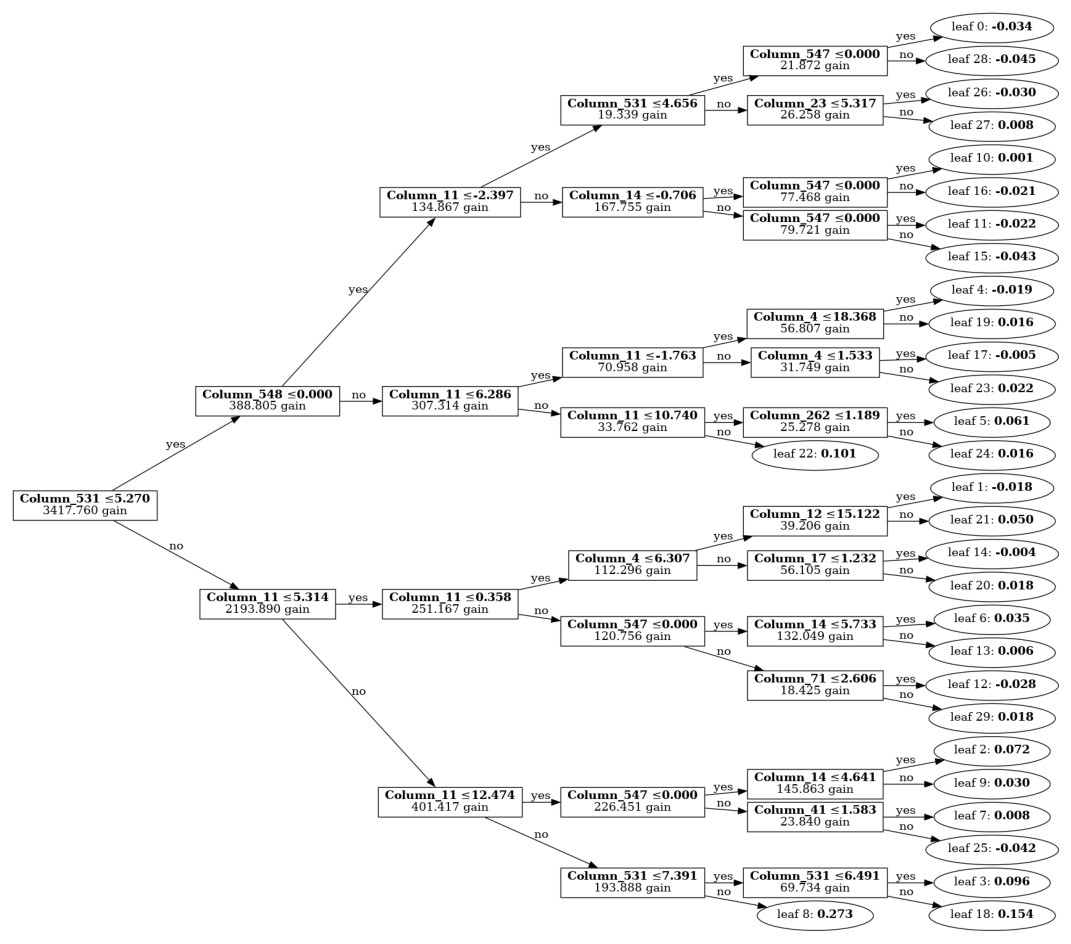

In [113]:
import lightgbm

fig = lgb.plot_tree(loaded_test_model, tree_index=5, figsize=(15,12), show_info=['split_gain'])

# Save the figure as a PNG image
plt.savefig('tree.png', dpi=300, bbox_inches='tight')

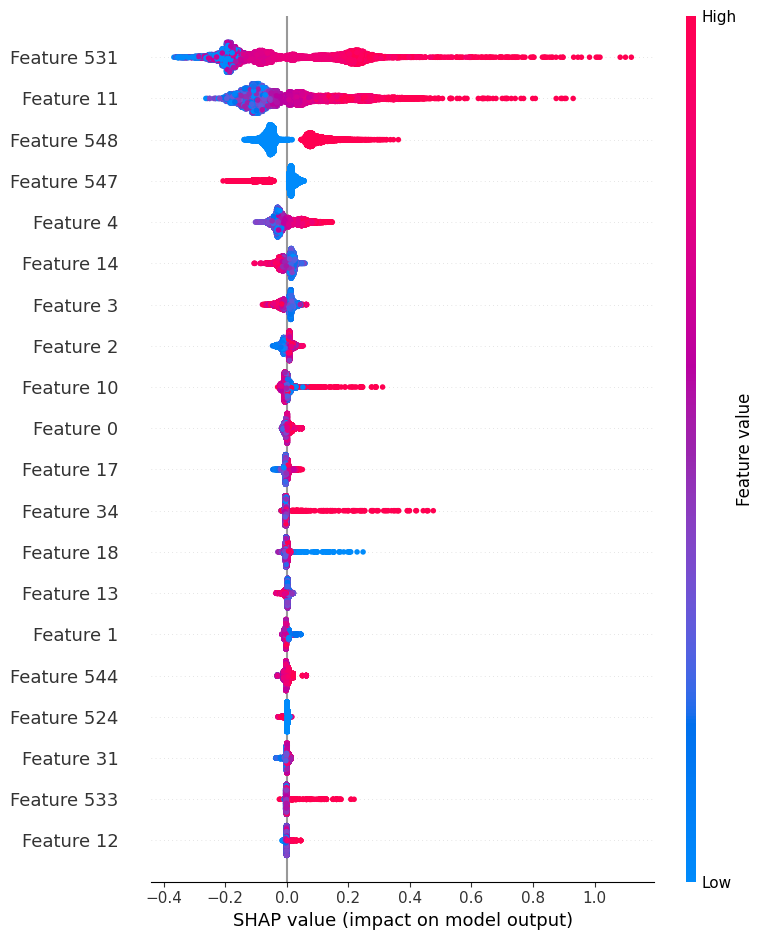

In [41]:
# LightGBM model explained by shap
import shap
import numpy as np
from scipy import sparse

b=sparse.csr_matrix(X_test)

# Convert sparse matrix to dense matrix
b_dense = b.toarray()

# Compute SHAP values
explainer = shap.TreeExplainer(loaded_test_model)
shap_values = explainer.shap_values(b_dense)

# Create a summary plot
shap.summary_plot(shap_values, b_dense)

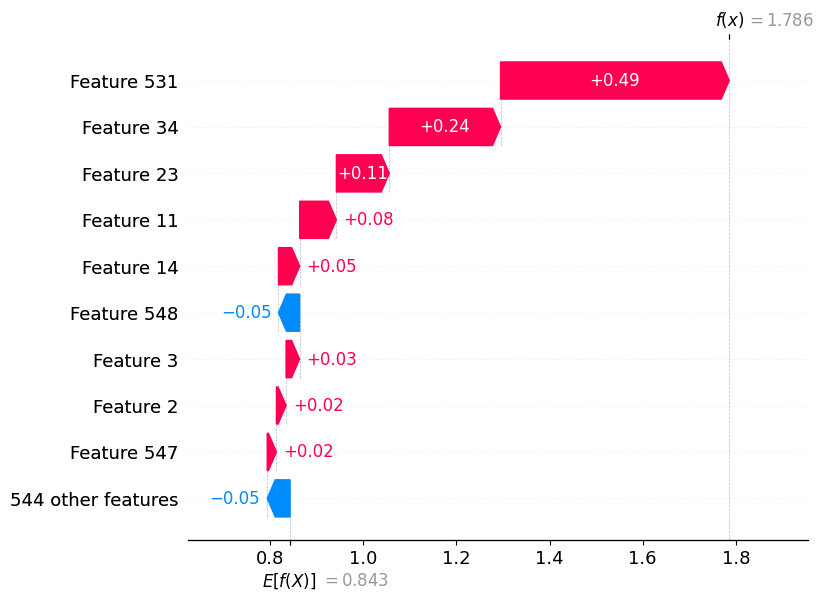

In [33]:
# Create Explanation object
shap_exp = shap.Explanation(values=shap_values[0], base_values=explainer.expected_value)

# Create a waterfall plot
# explanations for individual predictions
shap.plots.waterfall(shap_exp)

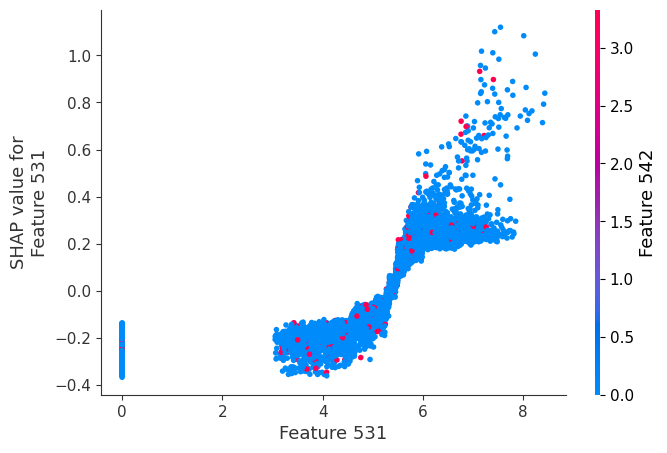

In [34]:
# color corresponds to a second feature that may have an interaction effect 
# with the feature we are plotting

# Each dot represents a row of the data
# x-axis - value of the feature
# y-axis - SHAP value for that feature, 
#          which represents how much knowing that feature's value changes 
#          the output of the model for that sample's prediction

shap.dependence_plot('Feature 531', shap_values, b_dense, interaction_index="Feature 542")

In [ ]:
# This shows how the model depends on the given feature
# If you don't supply an argument for interaction_index, 
# Shapley uses some logic to pick one that may be interesting.

shap.dependence_plot("Feature 531", shap_values,b_dense )

In [96]:
gene_name = ['ENSG00000134256_CD101', 'ENSG00000170458_CD14', 'ENSG00000177575_CD163', 'ENSG00000177455_CD19', 'ENSG00000116824_CD2', 'ENSG00000012124_CD22', 'ENSG00000150637_CD226', 'ENSG00000272398_CD24', 'ENSG00000122223_CD244', 'ENSG00000139193_CD27', 'ENSG00000120217_CD274', 'ENSG00000105383_CD33', 'ENSG00000135218_CD36', 'ENSG00000004468_CD38', 'ENSG00000010610_CD4', 'ENSG00000101017_CD40', 'ENSG00000026508_CD44', 'ENSG00000196776_CD47', 'ENSG00000117091_CD48', 'ENSG00000169442_CD52', 'ENSG00000116815_CD58', 'ENSG00000135404_CD63', 'ENSG00000110848_CD69', 'ENSG00000173762_CD7', 'ENSG00000137101_CD72', 'ENSG00000110651_CD81', 'ENSG00000085117_CD82', 'ENSG00000112149_CD83', 'ENSG00000114013_CD86', 'ENSG00000010278_CD9', 'ENSG00000125810_CD93', 'ENSG00000168329_CX3CR1', 'ENSG00000204592_HLA-E', 'ENSG00000139187_KLRG1']

import json

# Opening JSON file
f = open('/kaggle/input/variable-names/protein_list.json')
f_names = open('/kaggle/input/variable-names/features_names.json')

# returns JSON object as
# a dictionary

target_protiens = json.load(f)
target_protiens = json.loads(target_protiens)

feature_names = json.load(f_names)
feature_names = json.loads(feature_names)

In [80]:
correnspond_gene_pro = {}
for i, gene in enumerate(gene_name):
    for j, pro in enumerate(target_protiens):
        if gene.split('_')[1] == pro:
            print(f"gene_{gene}: {i} ---- {pro}: {j}")
            correnspond_gene_pro[j] = f"gene_{gene}: {i} ---- {pro}: {j}

gene_ENSG00000134256_CD101: 0 ---- CD101: 137
gene_ENSG00000170458_CD14: 1 ---- CD14: 25
gene_ENSG00000177575_CD163: 2 ---- CD163: 91
gene_ENSG00000177455_CD19: 3 ---- CD19: 13
gene_ENSG00000116824_CD2: 4 ---- CD2: 95
gene_ENSG00000012124_CD22: 5 ---- CD22: 107
gene_ENSG00000150637_CD226: 6 ---- CD226: 96
gene_ENSG00000272398_CD24: 7 ---- CD24: 71
gene_ENSG00000122223_CD244: 8 ---- CD244: 75
gene_ENSG00000139193_CD27: 9 ---- CD27: 53
gene_ENSG00000120217_CD274: 10 ---- CD274: 1
gene_ENSG00000105383_CD33: 11 ---- CD33: 14
gene_ENSG00000135218_CD36: 12 ---- CD36: 113
gene_ENSG00000004468_CD38: 13 ---- CD38: 104
gene_ENSG00000010610_CD4: 14 ---- CD4: 23
gene_ENSG00000101017_CD40: 15 ---- CD40: 7
gene_ENSG00000026508_CD44: 16 ---- CD44: 24
gene_ENSG00000196776_CD47: 17 ---- CD47: 5
gene_ENSG00000117091_CD48: 18 ---- CD48: 6
gene_ENSG00000169442_CD52: 19 ---- CD52: 9
gene_ENSG00000116815_CD58: 20 ---- CD58: 68
gene_ENSG00000135404_CD63: 21 ---- CD63: 111
gene_ENSG00000110848_CD69: 22 ---- C

In [82]:
import matplotlib.pyplot as plt
correnspond_gene_pro

{137: 'gene_ENSG00000134256_CD101: 0 ---- CD101: 137',
 25: 'gene_ENSG00000170458_CD14: 1 ---- CD14: 25',
 91: 'gene_ENSG00000177575_CD163: 2 ---- CD163: 91',
 13: 'gene_ENSG00000177455_CD19: 3 ---- CD19: 13',
 95: 'gene_ENSG00000116824_CD2: 4 ---- CD2: 95',
 107: 'gene_ENSG00000012124_CD22: 5 ---- CD22: 107',
 96: 'gene_ENSG00000150637_CD226: 6 ---- CD226: 96',
 71: 'gene_ENSG00000272398_CD24: 7 ---- CD24: 71',
 75: 'gene_ENSG00000122223_CD244: 8 ---- CD244: 75',
 53: 'gene_ENSG00000139193_CD27: 9 ---- CD27: 53',
 1: 'gene_ENSG00000120217_CD274: 10 ---- CD274: 1',
 14: 'gene_ENSG00000105383_CD33: 11 ---- CD33: 14',
 113: 'gene_ENSG00000135218_CD36: 12 ---- CD36: 113',
 104: 'gene_ENSG00000004468_CD38: 13 ---- CD38: 104',
 23: 'gene_ENSG00000010610_CD4: 14 ---- CD4: 23',
 7: 'gene_ENSG00000101017_CD40: 15 ---- CD40: 7',
 24: 'gene_ENSG00000026508_CD44: 16 ---- CD44: 24',
 5: 'gene_ENSG00000196776_CD47: 17 ---- CD47: 5',
 6: 'gene_ENSG00000117091_CD48: 18 ---- CD48: 6',
 9: 'gene_ENSG00

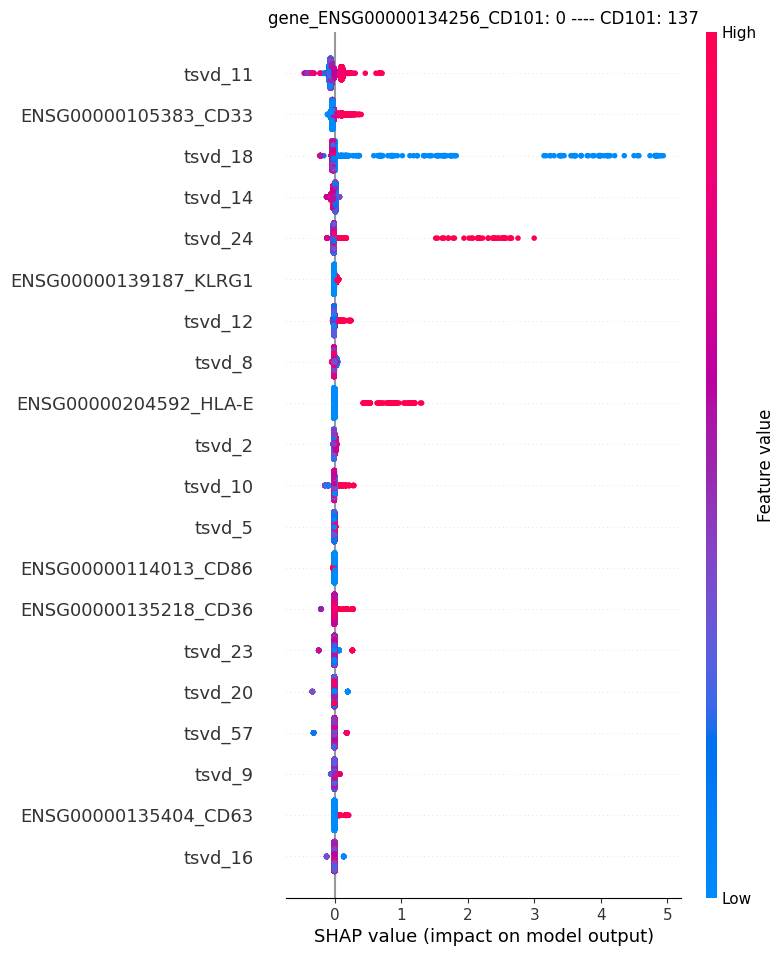

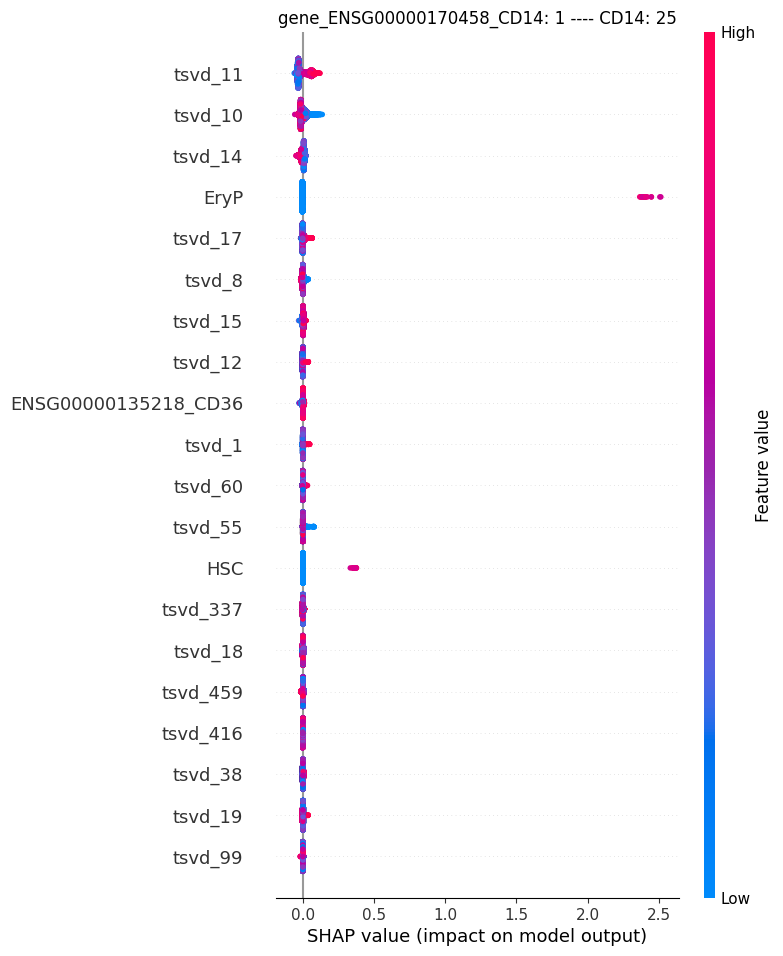

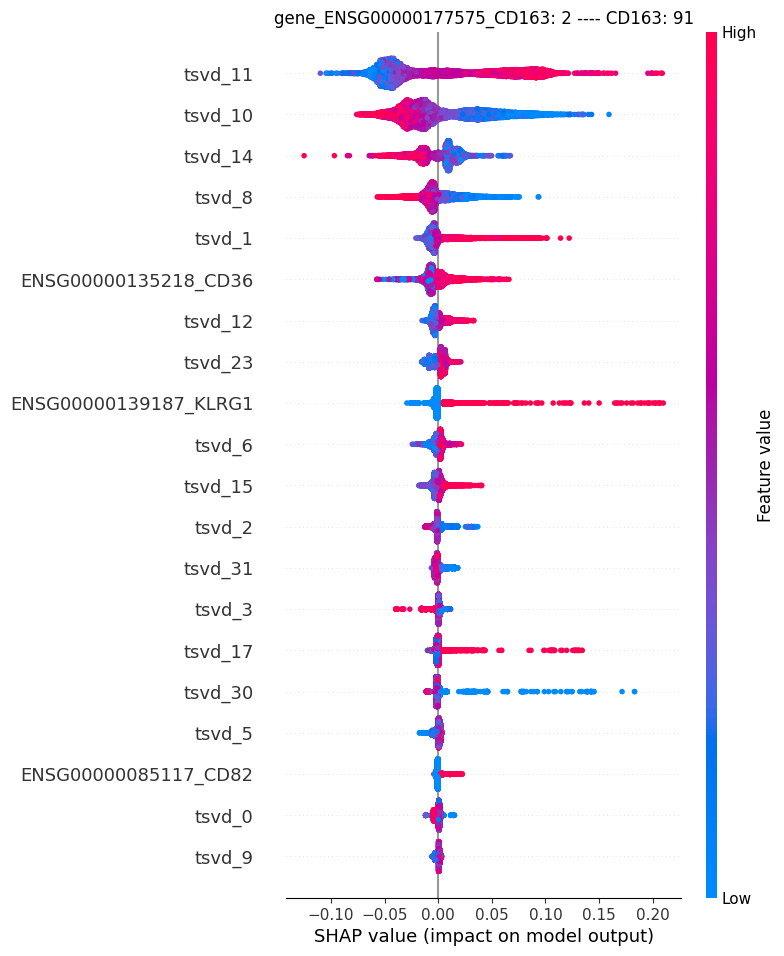

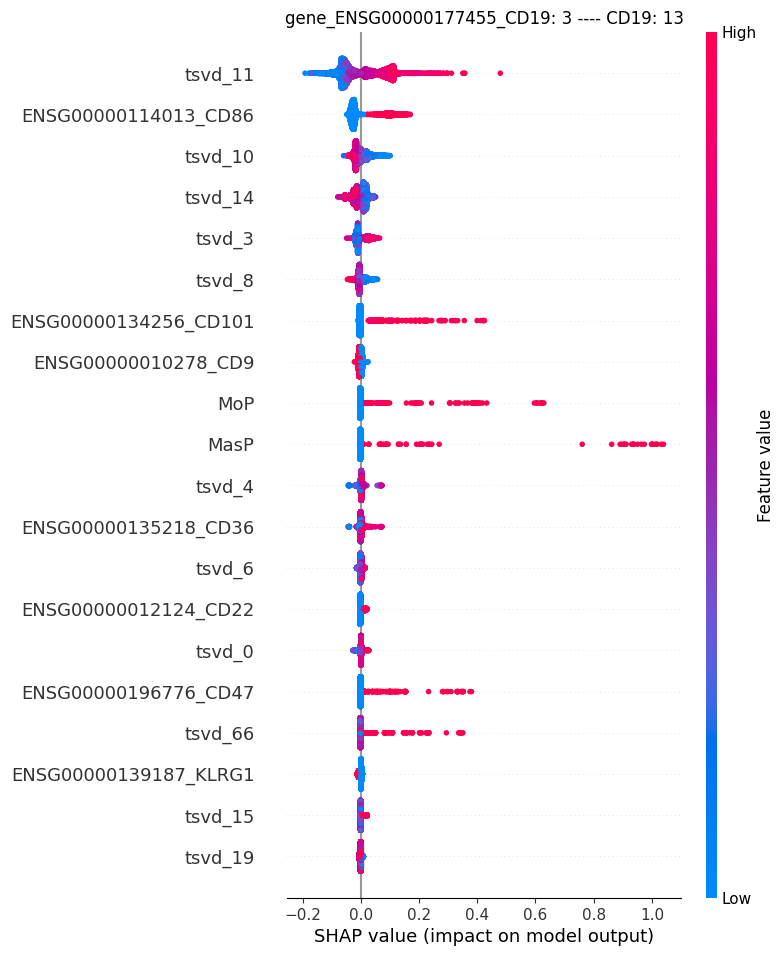

KeyboardInterrupt: 

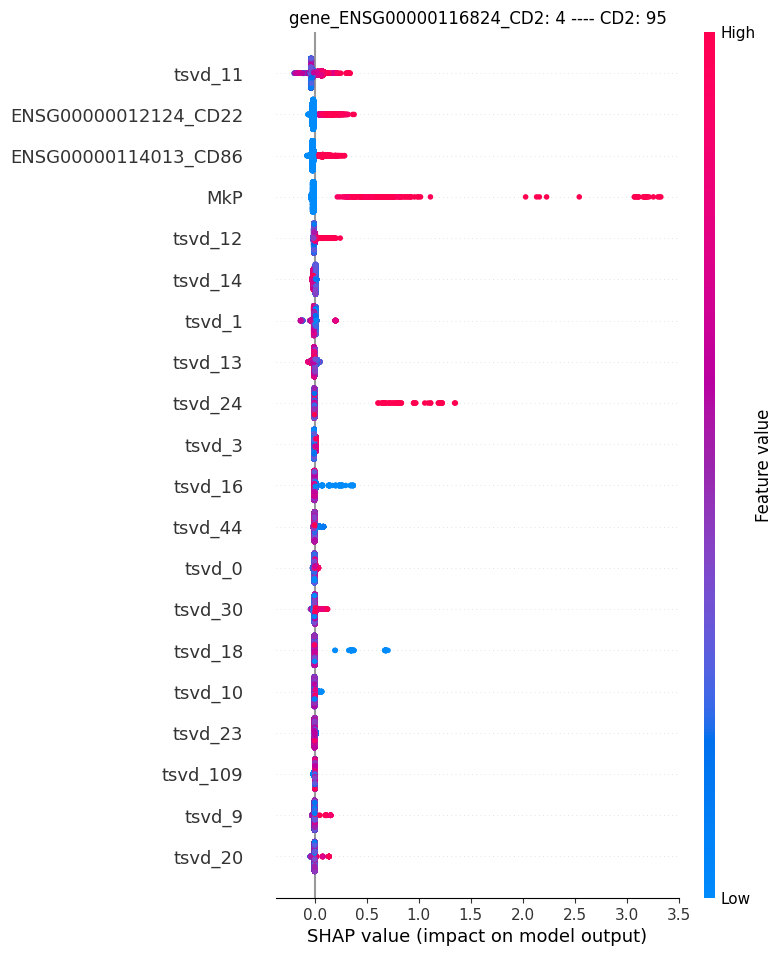

In [119]:
## fit in indivisual model

# Get the keys using the keys() method
keys = correnspond_gene_pro.keys()

# Convert the keys to a list
key_list = list(correnspond_gene_pro)

for key, val in correnspond_gene_pro.items():
    models = f'/kaggle/input/models/test_filename_{key}'
    loaded_model = pickle.load(open(models, 'rb'))

    b=sparse.csr_matrix(X_test)

    # Convert sparse matrix to dense matrix
    b_dense = b.toarray()

    # Compute SHAP values
    explainer= shap.TreeExplainer(loaded_model)
    shap_values = explainer.shap_values(b_dense)

    # Create a summary plot
    shap.summary_plot(shap_values, b_dense, feature_names=feature_names, show=False)
    plt.title(val)     
    plt.savefig(f'/kaggle/working/protein_{i}.png')
    plt.show()

In [21]:
# using test-model fit in proessed test-dataset
test_input = torch.from_numpy(np.load("/kaggle/input/test-dataset/cite_test_X.npy"))

result = pd.DataFrame() # final predicted value
for i in range(num_columns):
    test_y_pred_va = loaded_test_model.predict(test_input)
    result[i] = test_y_pred_va
    del test_y_pred_va

/tmp/ipykernel_34/1964878855.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result[i] = test_y_pred_va
/tmp/ipykernel_34/1964878855.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result[i] = test_y_pred_va
/tmp/ipykernel_34/1964878855.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resu

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


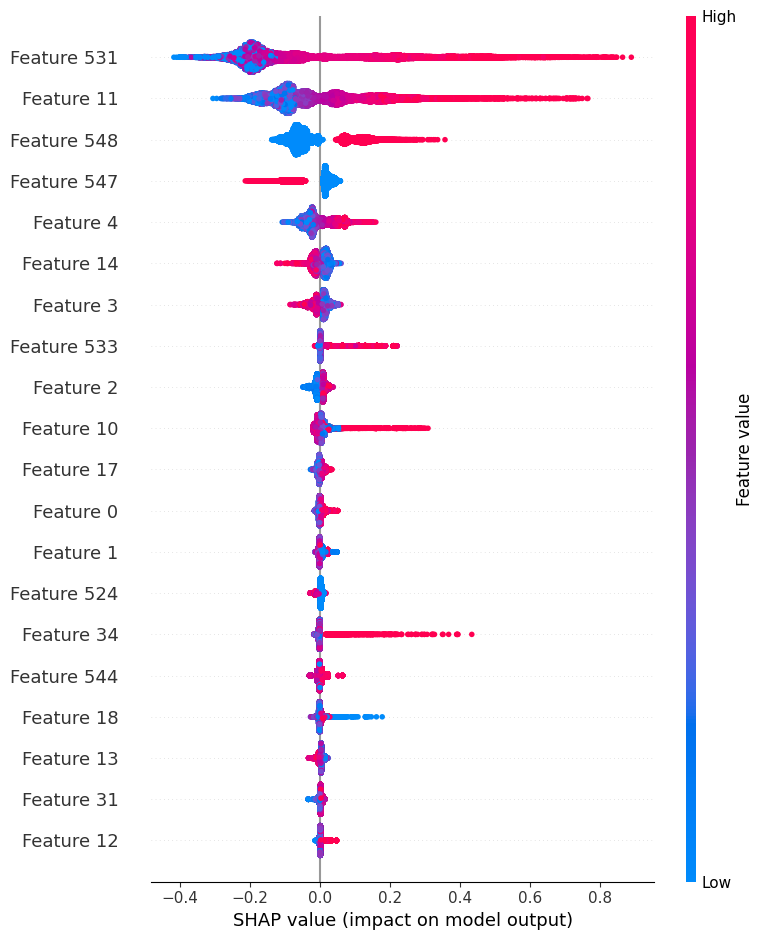

In [36]:
b_test=sparse.csr_matrix(test_input)

# Convert sparse matrix to dense matrix
b_test_dense = b_test.toarray()

# Compute SHAP values
shap_values_test = explainer.shap_values(b_test_dense)

# Create a summary plot
shap.summary_plot(shap_values_test, b_test_dense)

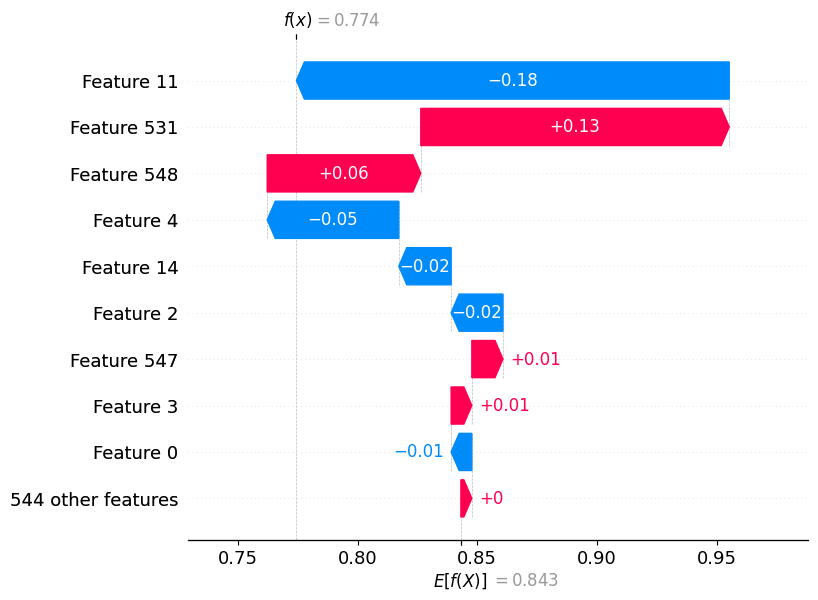

In [37]:
# Create Explanation object
shap_exp_test = shap.Explanation(values=shap_values_test[0], base_values=explainer.expected_value)

# Create a waterfall plot
# explanations for individual predictions
shap.plots.waterfall(shap_exp_test)

In [ ]:
# multioutputregresson model

model.fit(X_train, y_train)

y_va_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_va_pred)
print(mse)
del train_input, Y
gc.collect()

In [ ]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

In [ ]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

In [ ]:
correlation_score(y_test,y_va_pred)

In [ ]:
! zip -r models.zip .

In [ ]:
! zip -r /kaggle/working/models.zip .